Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

# import from sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier

from torch.utils.data import TensorDataset, DataLoader

# import from xgboost
from xgboost import XGBClassifier, plot_importance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cpu


Load dataset

In [35]:
df = pd.read_csv("synthetic_coffee_health_10000.csv")

Properties of the dataset

In [36]:
print("Shape:", df.shape)    # rows x cols

Shape: (10000, 16)


In [37]:
print("Column types:")
print(df.dtypes)

Column types:
ID                           int64
Age                          int64
Gender                      object
Country                     object
Coffee_Intake              float64
Caffeine_mg                float64
Sleep_Hours                float64
Sleep_Quality               object
BMI                        float64
Heart_Rate                   int64
Stress_Level                object
Physical_Activity_Hours    float64
Health_Issues               object
Occupation                  object
Smoking                      int64
Alcohol_Consumption          int64
dtype: object


In [38]:
print("First 5 rows:")
display(df.head())

First 5 rows:


,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


Check for missing values

In [39]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
ID                            0
Age                           0
Gender                        0
Country                       0
Coffee_Intake                 0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64


The Health_Issues column has 5941 missing values out of 10000 entries. We will inspect this further.

In [40]:
print(df["Health_Issues"].value_counts())

Health_Issues
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64


Looking at the dataset, the 5941 missing values in the Health_Issues column are actually just None - as in no health issues. The system interprets this to be the None keyword = missing value. So we will rename all of these entries so they are no longer considered as missing values.

In [41]:
df["Health_Issues"] = df["Health_Issues"].fillna("No_issues")
print(df["Health_Issues"].value_counts())

Health_Issues
No_issues    5941
Mild         3579
Moderate      463
Severe         17
Name: count, dtype: int64


Now, we check again for missing values.

In [42]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
ID                         0
Age                        0
Gender                     0
Country                    0
Coffee_Intake              0
Caffeine_mg                0
Sleep_Hours                0
Sleep_Quality              0
BMI                        0
Heart_Rate                 0
Stress_Level               0
Physical_Activity_Hours    0
Health_Issues              0
Occupation                 0
Smoking                    0
Alcohol_Consumption        0
dtype: int64


There are no missing values now.

Now we will perfrom data preprocessing.

In [43]:
# check data types
print(df.dtypes)

ID                           int64
Age                          int64
Gender                      object
Country                     object
Coffee_Intake              float64
Caffeine_mg                float64
Sleep_Hours                float64
Sleep_Quality               object
BMI                        float64
Heart_Rate                   int64
Stress_Level                object
Physical_Activity_Hours    float64
Health_Issues               object
Occupation                  object
Smoking                      int64
Alcohol_Consumption          int64
dtype: object


Now we can define the features and target vectors for our classification. We will start with XGBoost best model paramaters out of 15 features.

In [44]:
def get_important_features(X_train, y_train):
    feature_xgb_model = XGBClassifier(
        n_estimators=100,    # number of boosting rounds = 100 trees
        max_depth=5,    # complexity of each tree
        learning_rate=0.1,    # step size
        eval_metric='mlogloss',
        random_state=42
    )
    
    feature_xgb_model.fit(X_train, y_train)
    
    # get the important features
    importance = feature_xgb_model.get_booster().get_score(importance_type='gain')
    
    # get the list of features with their importance
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    })
    
    # sorting the importance and printing
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    return importance_df

In [45]:
def encode_vectors(feature):
    # get the feature and target vectors
    X = df.drop(feature, axis=1)
    y = df[feature].values

    print("Feature vector shape:", X.shape)    # rows x cols
    print("Target vector shape:", y.shape)    # rows x cols

    # Encode all the non-integer or non-float features
    # create and fit encoder to map target values  ['Low','Medium','High'] -> [0,1,2]
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    df_encoded = X.copy()
    # encode feature object values
    for col in df_encoded.select_dtypes(include=['object']).columns:
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

    #Split into test and validation data sets
    X_train, X_val, y_train, y_val = train_test_split(df_encoded, y_encoded, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val, encoder, df_encoded

In [46]:
# get the feature and target vectors
X_train, X_val, y_train, y_val, encoder, df_encoded = encode_vectors("Stress_Level")

importance_df = get_important_features(X_train,y_train)
print(importance_df)

Feature vector shape: (10000, 15)
Target vector shape: (10000,)
         Feature  Importance
1    Sleep_Hours  147.872147
2  Sleep_Quality  106.564705
3  Health_Issues    0.263107
0            Age    0.001113


As we can recognize from the chart above, features Sleep_Hours and Sleep_Quality contribute the most to stress levels. Since we are trying to find correlation between coffee intake and stress levels, we can look at the cause of sleep quality and health issues.

In [47]:
# get the importance for ["Sleep_Quality"]
print("Displaying the important features for Sleep_Quality:")
X_train_sq, X_val_sq, y_train_sq, y_val_sq, encoder_sq, df_encoded_sq = encode_vectors("Sleep_Quality")

importance_df_sq = get_important_features(X_train_sq,y_train_sq)
print(importance_df_sq)

# get the importance for ["Health_Issues"]
print("Displaying the important features for Health_Issues:")
X_train_h, X_val_h, y_train_h, y_val_h, encoder_h, df_encoded_h = encode_vectors("Health_Issues")

importance_df_h = get_important_features(X_train_h,y_train_h)
print(importance_df_h)

Displaying the important features for Sleep_Quality:
Feature vector shape: (10000, 15)
Target vector shape: (10000,)
                    Feature  Importance
9              Stress_Level  186.804062
6               Sleep_Hours  104.592232
13                  Smoking    0.830071
8                Heart_Rate    0.806810
5               Caffeine_mg    0.804560
1                       Age    0.765175
10  Physical_Activity_Hours    0.747677
4             Coffee_Intake    0.698073
2                    Gender    0.679685
0                        ID    0.672650
12               Occupation    0.656590
7                       BMI    0.617288
3                   Country    0.588262
14      Alcohol_Consumption    0.210232
11            Health_Issues    0.194517
Displaying the important features for Health_Issues:
Feature vector shape: (10000, 15)
Target vector shape: (10000,)
                    Feature  Importance
6               Sleep_Hours   47.846870
1                       Age   29.993958
8     

For visual purposes, we can plot the importance with plot_importance from xgboost.

In [48]:
'''
# plotting Stress_Level importance features
plot_importance(xgb_model, max_num_features=10, importance_type='gain', title="Stress_Level Feature Importance")
plt.show()

# plotting Sleep_Quality importance features
plot_importance(xgb_model_sq, max_num_features=10, importance_type='gain', title="Sleep_Quality Feature Importance")
plt.show()

# plotting Health_Issues importance features
plot_importance(xgb_model_h, max_num_features=10, importance_type='gain', title="Health_Issues Feature Importance")
plt.show()
'''

'\n# plotting Stress_Level importance features\nplot_importance(xgb_model, max_num_features=10, importance_type=\'gain\', title="Stress_Level Feature Importance")\nplt.show()\n\n# plotting Sleep_Quality importance features\nplot_importance(xgb_model_sq, max_num_features=10, importance_type=\'gain\', title="Sleep_Quality Feature Importance")\nplt.show()\n\n# plotting Health_Issues importance features\nplot_importance(xgb_model_h, max_num_features=10, importance_type=\'gain\', title="Health_Issues Feature Importance")\nplt.show()\n'

As we can see, Caffeine_mg and Coffee_Intake does play a role in predicting the sleep hours and sleep quality which has an effect on stress levels and health issues.

Now that we have the important features, we can start training and validating models using xgboost with hyperparameter tuning.

In [49]:
def grid_search_func(model, X, y, param_grid):

    # set up grid search
    random_grid_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20, #20 random combinations
        scoring='accuracy',
        cv=3, # 3-fold cross-validation since one of the classes has only 3 samples for a y-value
        verbose=1, 
        refit=True, # automatically refit the best model on the full dataset
        random_state=42,
        n_jobs=-1
    )

    random_grid_search.fit(X, y)

    # return the best parameters, best score, best fitted model
    return random_grid_search.best_params_, random_grid_search.best_score_, random_grid_search.best_estimator_

def get_accuracy_cm(model, X_train, X_val, y_train, y_val, param_grid, feature, encoder):

    xgb_bp, xgb_bs, xgb_tuned_model = grid_search_func(model, X_train, y_train, param_grid)

    print(f"Best parameters: {xgb_bp}, Best score: {xgb_bs}\n")

    # get the predictions
    y_pred_train = xgb_tuned_model.predict(X_train) # training predictions
    y_pred_val = xgb_tuned_model.predict(X_val) # validation predictions

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)

    cm_train = confusion_matrix(y_train, y_pred_train) 
    cm_val = confusion_matrix(y_val, y_pred_val) 

    # displaying the confusion matrices and printing the classification report (precision, recall, f1-score, accuracy, etc.)
    disp_cm_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=encoder.classes_)
    disp_cm_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=encoder.classes_)

    disp_cm_train.plot(cmap='Greens', values_format='d')  # 'd' for integers
    plt.title(f"[{feature}] Training Confusion Matrix")
    plt.show()

    # print the classification report
    print(f"Training acurracy (%) score: {acc_train*100}\n")
    print(f"Printing classification report for training:\n {classification_report(y_train, y_pred_train, target_names=encoder.classes_)} \n") 

    disp_cm_val.plot(cmap='Greens', values_format='d')  # 'd' for integers
    plt.title(f"[{feature}] Validation Confusion Matrix")
    plt.show()

    # print the classification report
    print(f"Validation acurracy (%) score: {acc_val*100}\n")
    print(f"Printing classification report for validation:\n {classification_report(y_val, y_pred_val, target_names=encoder.classes_)} \n") 

    return acc_train, acc_val, cm_train, cm_val, xgb_tuned_model

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Best parameters: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.5}, Best score: 1.0



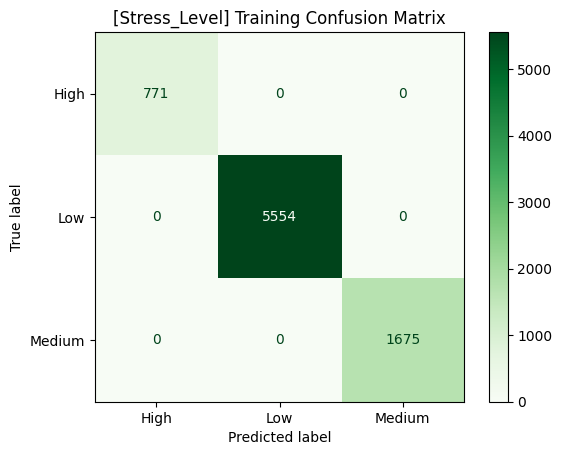

Training acurracy (%) score: 100.0

Printing classification report for training:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       771
         Low       1.00      1.00      1.00      5554
      Medium       1.00      1.00      1.00      1675

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000
 



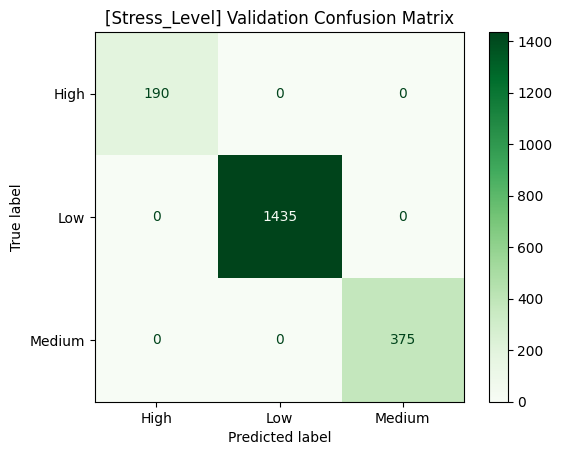

Validation acurracy (%) score: 100.0

Printing classification report for validation:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       190
         Low       1.00      1.00      1.00      1435
      Medium       1.00      1.00      1.00       375

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000
 



In [50]:
# define parameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'subsample': [0.5, 1.0],
    'colsample_bytree': [0.5, 1.0]
}

# select the 8 top features into list
top_2_features = importance_df['Feature'].head(2).tolist()
X_train_top2 = X_train[top_2_features]
X_val_top2 = X_val[top_2_features]

# new model for training
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)


acc_train, acc_val, cm_train, cm_val, best_mod = get_accuracy_cm(xgb_model, X_train_top2, X_val_top2, y_train, y_val, param_grid, "Stress_Level", encoder)

Due to the large available dataset and high importance pattern for predicting stress levels, our predictions are 100% accurate with this dataset. We can also try predicting the other factors such as Sleep_Quality, and Health_Issues to understand the correlation between coffee intake and health.

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}, Best score: 0.9934999685429419



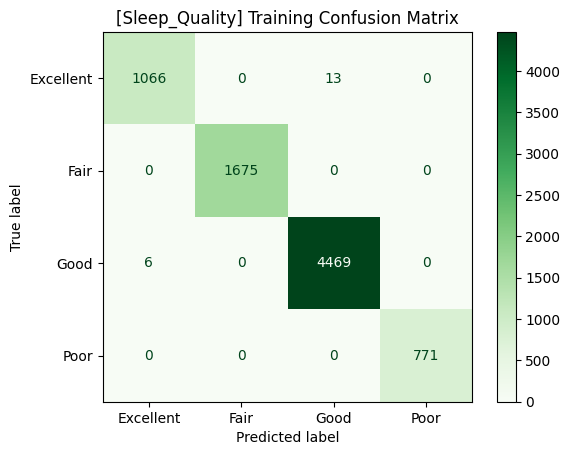

Training acurracy (%) score: 99.7625

Printing classification report for training:
               precision    recall  f1-score   support

   Excellent       0.99      0.99      0.99      1079
        Fair       1.00      1.00      1.00      1675
        Good       1.00      1.00      1.00      4475
        Poor       1.00      1.00      1.00       771

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000
 



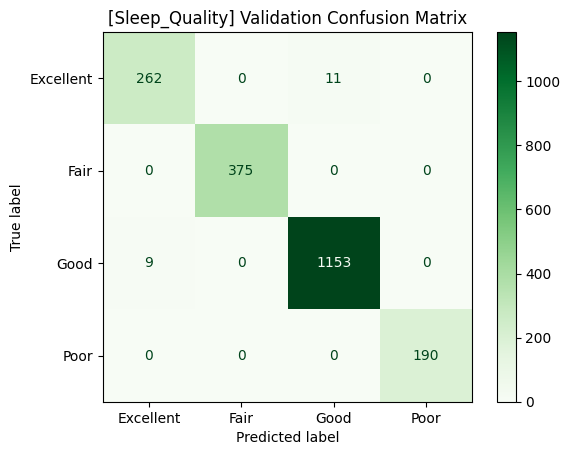

Validation acurracy (%) score: 99.0

Printing classification report for validation:
               precision    recall  f1-score   support

   Excellent       0.97      0.96      0.96       273
        Fair       1.00      1.00      1.00       375
        Good       0.99      0.99      0.99      1162
        Poor       1.00      1.00      1.00       190

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000
 

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}, Best score: 0.9978748905449084



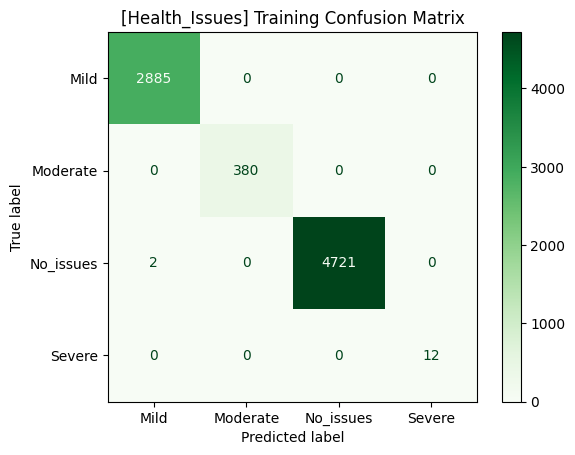

Training acurracy (%) score: 99.97500000000001

Printing classification report for training:
               precision    recall  f1-score   support

        Mild       1.00      1.00      1.00      2885
    Moderate       1.00      1.00      1.00       380
   No_issues       1.00      1.00      1.00      4723
      Severe       1.00      1.00      1.00        12

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000
 



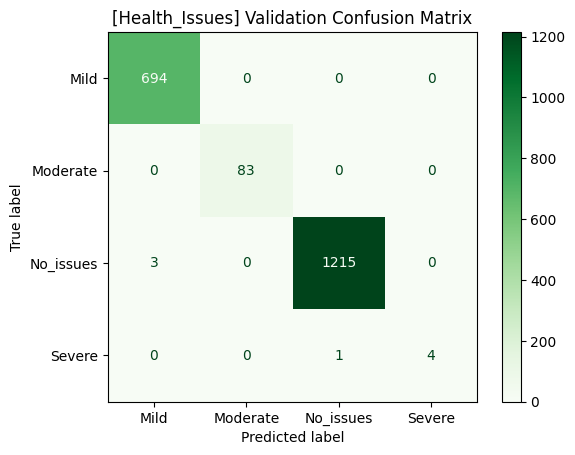

Validation acurracy (%) score: 99.8

Printing classification report for validation:
               precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       694
    Moderate       1.00      1.00      1.00        83
   No_issues       1.00      1.00      1.00      1218
      Severe       1.00      0.80      0.89         5

    accuracy                           1.00      2000
   macro avg       1.00      0.95      0.97      2000
weighted avg       1.00      1.00      1.00      2000
 



In [51]:
list_features = ["Sleep_Quality", "Health_Issues"]
list_importance_df = [ importance_df_sq, importance_df_h]
list_X_train = [X_train_sq, X_train_h]
list_X_val = [X_val_sq, X_val_h]
list_y_train = [y_train_sq, y_train_h]
list_y_val = [ y_val_sq, y_val_h]
list_encoder = [encoder_sq, encoder_h]

acc_dict = {}
for i in range(len(list_features)):

    # select the 8 top features into list
    top_8_features = list_importance_df[i]['Feature'].head(8).tolist()
    X_train_top8 = list_X_train[i][top_8_features]
    X_val_top8 = list_X_val[i][top_8_features]

    xgb_model_new = XGBClassifier(eval_metric='mlogloss', random_state=42)

    # plotting the confustion matrix for the feature
    acc_train, acc_val, cm_train, cm_val, bestmodel = get_accuracy_cm(xgb_model_new, X_train_top8, X_val_top8, list_y_train[i], list_y_val[i], param_grid, list_features[i], list_encoder[i])

    # add to dictionary to save accuracy and confusion matrix
    acc_dict[list_features[i]] = {
        'acc_train': acc_train,
        'acc_val': acc_val,
        'cm_train': cm_train,
        'cm_val': cm_val,
        'bestmodel': bestmodel
    }

Similarly, we perform all the steps for a random forest model for classification.

In [52]:
def get_importance_rf(X, y, n_estimators=200, max_depth=None):
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    rf_model.fit(X, y)

    importance = rf_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    return rf_model, importance_df

In [53]:
def grid_search_rf(model, X, y, param_grid):
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=20,
        scoring='accuracy',
        cv=3,
        verbose=1,
        refit=True,
        random_state=42,
        n_jobs=1
    )
    search.fit(X, y)
    return search.best_params_, search.best_score_, search.best_estimator_

In [54]:
def get_accuracy_cm_rf(model, X_train, X_val, y_train, y_val, param_grid, feature, encoder):
    best_params, best_score, tuned_model = grid_search_rf(model, X_train, y_train, param_grid)
    
    print(f"***Random Forest: {feature}***")
    print(f"Best parameters: {best_params}, Best CV score: {best_score:.4f}\n")

    y_pred_train = tuned_model.predict(X_train)
    y_pred_val = tuned_model.predict(X_val)

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_val = confusion_matrix(y_val, y_pred_val)

    # Plot confusion matrices
    ConfusionMatrixDisplay(cm_train, display_labels=encoder.classes_).plot(cmap='Blues', values_format='d')
    plt.title(f"[{feature}] RF Training Confusion Matrix")
    plt.show()
    # print the classification report
    print(f"Training acurracy (%) score: {acc_train*100}\n")
    print(f"Training Classification Report:\n{classification_report(y_train, y_pred_train, target_names=encoder.classes_)}\n")

    ConfusionMatrixDisplay(cm_val, display_labels=encoder.classes_).plot(cmap='Blues', values_format='d')
    plt.title(f"[{feature}] RF Validation Confusion Matrix")
    plt.show()
    # print the classification report
    print(f"Validation acurracy (%) score: {acc_val*100}\n")
    print(f"Validation Classification Report:\n{classification_report(y_val, y_pred_val, target_names=encoder.classes_)}\n")

    return acc_train, acc_val, cm_train, cm_val, tuned_model

In [55]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

Fitting 3 folds for each of 20 candidates, totalling 60 fits
***Random Forest: Stress_Level***
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}, Best CV score: 1.0000



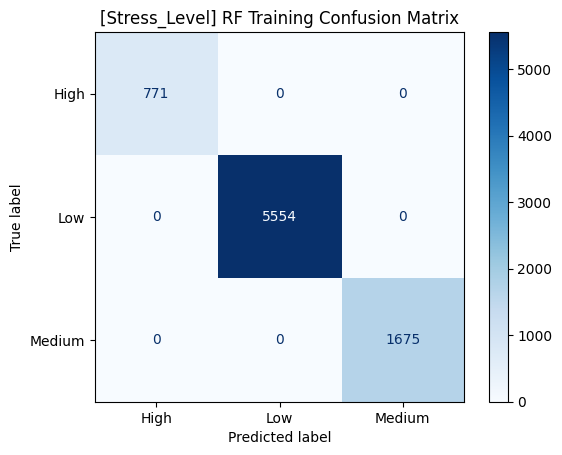

Training acurracy (%) score: 100.0

Training Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       771
         Low       1.00      1.00      1.00      5554
      Medium       1.00      1.00      1.00      1675

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000




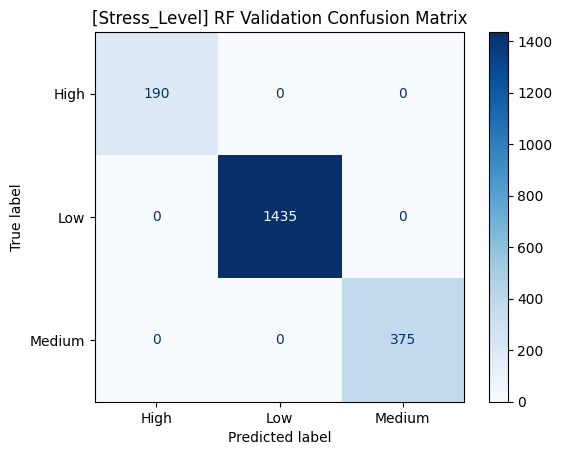

Validation acurracy (%) score: 100.0

Validation Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       190
         Low       1.00      1.00      1.00      1435
      Medium       1.00      1.00      1.00       375

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000




In [56]:
# Stress_Level
rf_model, rf_importance_df = get_importance_rf(X_train, y_train)
top_2_features = rf_importance_df['Feature'].head(2).tolist()
X_train_top2 = X_train[top_2_features]
X_val_top2 = X_val[top_2_features]

rf_acc_train, rf_acc_val, rf_cm_train, rf_cm_val, tuned_rf_model = get_accuracy_cm_rf(
    RandomForestClassifier(random_state=42), X_train_top2, X_val_top2, y_train, y_val, rf_param_grid, "Stress_Level", encoder
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
***Random Forest: Sleep_Quality***
Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}, Best CV score: 0.9943



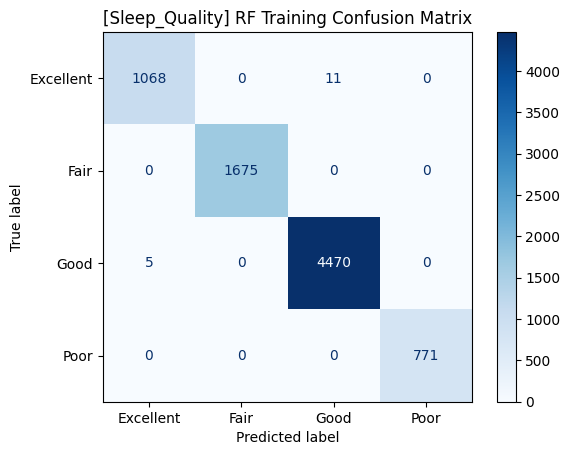

Training acurracy (%) score: 99.8

Training Classification Report:
              precision    recall  f1-score   support

   Excellent       1.00      0.99      0.99      1079
        Fair       1.00      1.00      1.00      1675
        Good       1.00      1.00      1.00      4475
        Poor       1.00      1.00      1.00       771

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000




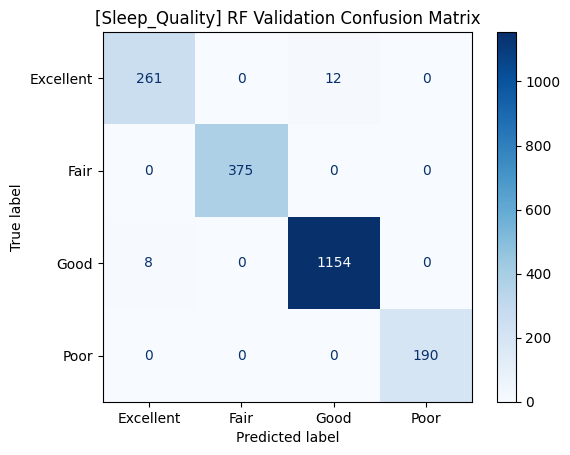

Validation acurracy (%) score: 99.0

Validation Classification Report:
              precision    recall  f1-score   support

   Excellent       0.97      0.96      0.96       273
        Fair       1.00      1.00      1.00       375
        Good       0.99      0.99      0.99      1162
        Poor       1.00      1.00      1.00       190

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Fitting 3 folds for each of 20 candidates, totalling 60 fits
***Random Forest: Health_Issues***
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}, Best CV score: 0.9988



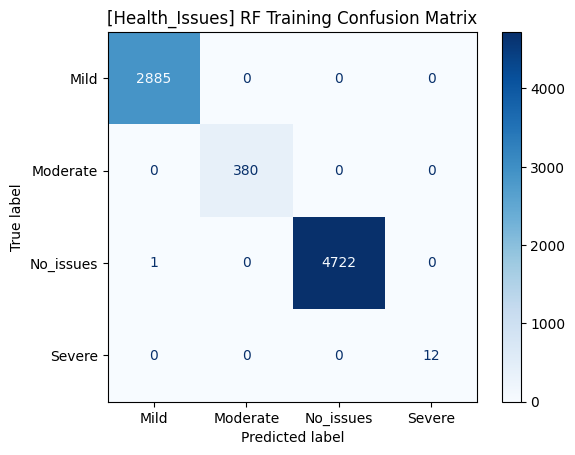

Training acurracy (%) score: 99.9875

Training Classification Report:
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00      2885
    Moderate       1.00      1.00      1.00       380
   No_issues       1.00      1.00      1.00      4723
      Severe       1.00      1.00      1.00        12

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000




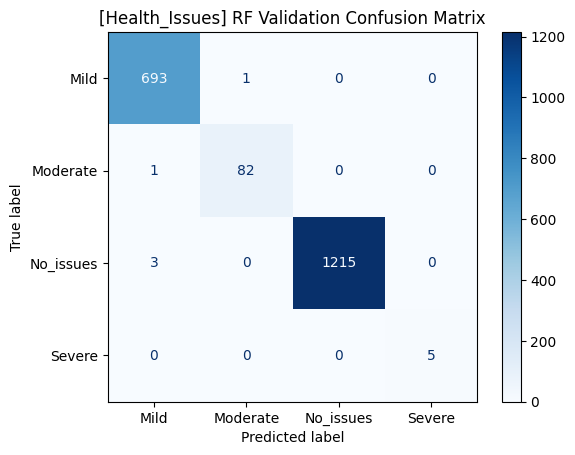

Validation acurracy (%) score: 99.75

Validation Classification Report:
              precision    recall  f1-score   support

        Mild       0.99      1.00      1.00       694
    Moderate       0.99      0.99      0.99        83
   No_issues       1.00      1.00      1.00      1218
      Severe       1.00      1.00      1.00         5

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000




In [57]:
# Sleep_Quality and Health_Issues
list_features = ["Sleep_Quality", "Health_Issues"]
list_importance_df = [importance_df_sq, importance_df_h]
list_X_train = [X_train_sq, X_train_h]
list_X_val = [X_val_sq, X_val_h]
list_y_train = [y_train_sq, y_train_h]
list_y_val = [y_val_sq, y_val_h]
list_encoder = [encoder_sq, encoder_h]

rf_acc_dict = {}
for i in range(len(list_features)):
    top_8_features = list_importance_df[i]['Feature'].head(8).tolist()
    X_train_top8 = list_X_train[i][top_8_features]
    X_val_top8 = list_X_val[i][top_8_features]

    acc_train, acc_val, cm_train, cm_val, best_model = get_accuracy_cm_rf(
        RandomForestClassifier(random_state=42),
        X_train_top8,
        X_val_top8,
        list_y_train[i],
        list_y_val[i],
        rf_param_grid,
        list_features[i],
        list_encoder[i]
    )

    rf_acc_dict[list_features[i]] = {
        'acc_train': acc_train,
        'acc_val': acc_val,
        'cm_train': cm_train,
        'cm_val': cm_val,
        'bestmodel': best_model
    }

Now, for the neural network, we want to switch to one-hot vectors so the neural network will not interpret the encoded integers as having an ordinal meanings.

In [58]:
def encode_hot_vectors(feature):

    #separate features and  target
    X = df.drop(columns=[feature])
    y = df[feature].values

    #encode target lables
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    #one-hot encode categorical input features
    df_encoded = pd.get_dummies(X, drop_first=False)

    #Split into test and validation data sets
    X_train, X_val, y_train, y_val = train_test_split(df_encoded, y_encoded, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val, encoder, df_encoded

In [83]:
# get the feature and target vectors stress level
X_train_s, X_val_s, y_train_s, y_val_s, encoder_s, df_encoded_s = encode_hot_vectors("Stress_Level")


# scale features
scaler = StandardScaler()
X_train_scaled_s = scaler.fit_transform(X_train_s)
X_val_scaled_s = scaler.transform(X_val_s)

# convert to tensors
X_train_t_s = torch.tensor(X_train_scaled_s, dtype=torch.float32)
X_val_t_s = torch.tensor(X_val_scaled_s, dtype=torch.float32)

y_train_t_s= torch.tensor(y_train_s, dtype=torch.float32)
y_val_t_s = torch.tensor(y_val_s, dtype=torch.float32)

# build data loeaders
train_dataset_s = TensorDataset(X_train_t_s, y_train_t_s)
val_dataset_s = TensorDataset(X_val_t_s, y_val_t_s)

train_loader_s = DataLoader(train_dataset_s, batch_size=64, shuffle=True)
val_loader_s = DataLoader(val_dataset_s, batch_size=64, shuffle=False)


#Health issues
# get the feature and target vectors 
X_train_h, X_val_h, y_train_h, y_val_h, encoder_h, df_encoded_h = encode_hot_vectors("Health_Issues")

# scale features
scaler = StandardScaler()
X_train_scaled_h = scaler.fit_transform(X_train_h)
X_val_scaled_h = scaler.transform(X_val_h)

# convert to tensors
X_train_t_h = torch.tensor(X_train_scaled_h, dtype=torch.float32)
X_val_t_h = torch.tensor(X_val_scaled_h, dtype=torch.float32)

y_train_t_h = torch.tensor(y_train_h, dtype=torch.float32)
y_val_t_h = torch.tensor(y_val_h, dtype=torch.float32)

# build data loeaders
train_dataset_h = TensorDataset(X_train_t_h, y_train_t_h)
val_dataset_h = TensorDataset(X_val_t_h, y_val_t_h)

train_loader_h = DataLoader(train_dataset_h, batch_size=64, shuffle=True)
val_loader_h = DataLoader(val_dataset_h, batch_size=64, shuffle=False)


#Sleep quality
# get the feature and target vectors 
X_train_sq, X_val_sq, y_train_sq, y_val_sq, encoder_sq, df_encoded_sq = encode_hot_vectors("Sleep_Quality")

# scale features
scaler_sq = StandardScaler()
X_train_scaled_sq= scaler.fit_transform(X_train_sq)
X_val_scaled_sq = scaler.transform(X_val_sq)

# convert to tensors
X_train_t_sq = torch.tensor(X_train_scaled_sq, dtype=torch.float32)
X_val_t_sq = torch.tensor(X_val_scaled_sq, dtype=torch.float32)

y_train_t_sq = torch.tensor(y_train_sq, dtype=torch.float32)
y_val_t_sq = torch.tensor(y_val_sq, dtype=torch.float32)

# build data loeaders
train_dataset_sq = TensorDataset(X_train_t_sq, y_train_t_sq)
val_dataset_sq = TensorDataset(X_val_t_sq, y_val_t_sq)

train_loader_sq = DataLoader(train_dataset_sq, batch_size=64, shuffle=True)
val_loader_sq = DataLoader(val_dataset_sq, batch_size=64, shuffle=False)



Neural Network Model.

In [73]:
class NeuralNetwork(nn.Module):
    
    # __init__ function initializes the layers
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32) # first connected layer with 32 neurons
        self.fc2 = nn.Linear(32, 16) # second connected layer with 16 neurons
        self.fc3 = nn.Linear(16,num_classes) # last connected layer with 1 neuron

        # batch normalization
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(16)

    # forward function is the passing through / application of activation functions
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x))) # first layer + ReLU
        x = F.relu(self.bn2(self.fc2(x))) # second layer + ReLU
        x = self.fc3(x) # last layer

        return x

In [81]:
def get_accuracy_cm_nn(model, X_train, X_val, y_train, y_val, feature, encoder):

    model.eval()

    X_train_t = X_train.to(device)
    X_val_t = X_val.to(device)

    
    # forward pass for prediction
    with torch.no_grad():
        # get the predictions
        logits_train = model(X_train_t)
        logits_val = model(X_val_t)

        y_pred_train = logits_train.argmax(dim=1).cpu().numpy()
        y_pred_val = logits_val.argmax(dim=1).cpu().numpy()

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_val = accuracy_score(y_val, y_pred_val)

    cm_train = confusion_matrix(y_train, y_pred_train) 
    cm_val = confusion_matrix(y_val, y_pred_val) 

    # displaying the confusion matrices and printing the classification report (precision, recall, f1-score, accuracy, etc.)
    disp_cm_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=encoder.classes_)
    disp_cm_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=encoder.classes_)

    disp_cm_train.plot(cmap='Reds', values_format='d')  # 'd' for integers
    plt.title(f"[{feature}] Training Confusion Matrix")
    plt.show()

    # print the classification report
    print(f"Training acurracy (%) score: {acc_train*100}\n")
    print(f"Printing classification report for training:\n {classification_report(y_train, y_pred_train, target_names=encoder.classes_)} \n") 

    disp_cm_val.plot(cmap='Reds', values_format='d')  # 'd' for integers
    plt.title(f"[{feature}] Validation Confusion Matrix")
    plt.show()

    # print the classification report
    print(f"Validation acurracy (%) score: {acc_val*100}\n")
    print(f"Printing classification report for validation:\n {classification_report(y_val, y_pred_val, target_names=encoder.classes_)} \n") 

    return acc_train, acc_val, cm_train, cm_val

def train_nn(model, epochs, l1_lambda, optimizer, criterion, train_loader):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).long()

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            l1_loss = l1_lambda*model.fc1.weight.abs().sum()
            loss = loss + l1_loss
            
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} | loss: {loss.item():.4f}")
    return model

Now training the model

Epoch 1/20 | loss: 0.1990
Epoch 2/20 | loss: 0.0578
Epoch 3/20 | loss: 0.0256
Epoch 4/20 | loss: 0.0185
Epoch 5/20 | loss: 0.0126
Epoch 6/20 | loss: 0.0155
Epoch 7/20 | loss: 0.0099
Epoch 8/20 | loss: 0.0079
Epoch 9/20 | loss: 0.0063
Epoch 10/20 | loss: 0.0054
Epoch 11/20 | loss: 0.0064
Epoch 12/20 | loss: 0.0042
Epoch 13/20 | loss: 0.0035
Epoch 14/20 | loss: 0.0029
Epoch 15/20 | loss: 0.0027
Epoch 16/20 | loss: 0.0023
Epoch 17/20 | loss: 0.0019
Epoch 18/20 | loss: 0.0025
Epoch 19/20 | loss: 0.0013
Epoch 20/20 | loss: 0.0015


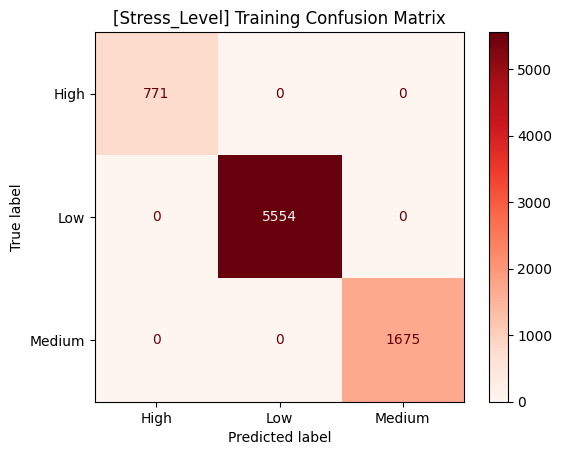

Training acurracy (%) score: 100.0

Printing classification report for training:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       771
         Low       1.00      1.00      1.00      5554
      Medium       1.00      1.00      1.00      1675

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000
 



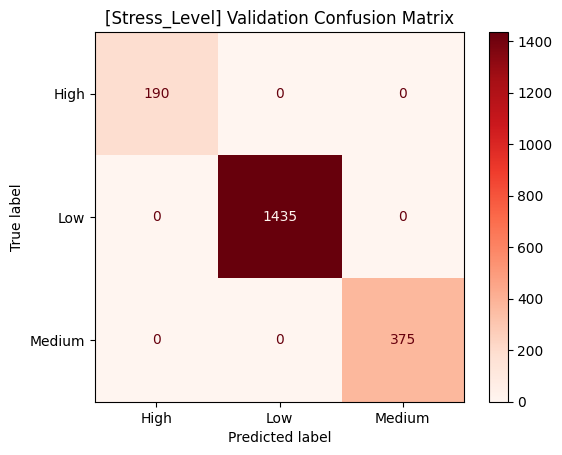

Validation acurracy (%) score: 100.0

Printing classification report for validation:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00       190
         Low       1.00      1.00      1.00      1435
      Medium       1.00      1.00      1.00       375

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000
 

Epoch 1/20 | loss: 0.5471
Epoch 2/20 | loss: 0.3369
Epoch 3/20 | loss: 0.1088
Epoch 4/20 | loss: 0.0899
Epoch 5/20 | loss: 0.0594
Epoch 6/20 | loss: 0.0973
Epoch 7/20 | loss: 0.0763
Epoch 8/20 | loss: 0.0750
Epoch 9/20 | loss: 0.0912
Epoch 10/20 | loss: 0.1073
Epoch 11/20 | loss: 0.0672
Epoch 12/20 | loss: 0.0653
Epoch 13/20 | loss: 0.1108
Epoch 14/20 | loss: 0.0205
Epoch 15/20 | loss: 0.0370
Epoch 16/20 | loss: 0.0355
Epoch 17/20 | loss: 0.0394
Epoch 18/20 | loss: 0.1124
Epoch 19/20 | loss: 0.0593
Epoch 20/20 | loss: 0.0775


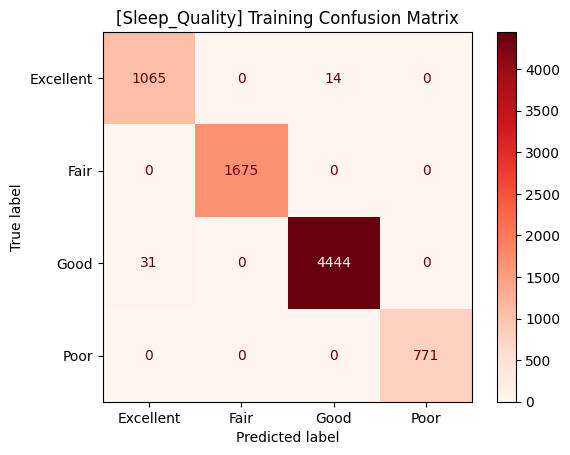

Training acurracy (%) score: 99.4375

Printing classification report for training:
               precision    recall  f1-score   support

   Excellent       0.97      0.99      0.98      1079
        Fair       1.00      1.00      1.00      1675
        Good       1.00      0.99      0.99      4475
        Poor       1.00      1.00      1.00       771

    accuracy                           0.99      8000
   macro avg       0.99      1.00      0.99      8000
weighted avg       0.99      0.99      0.99      8000
 



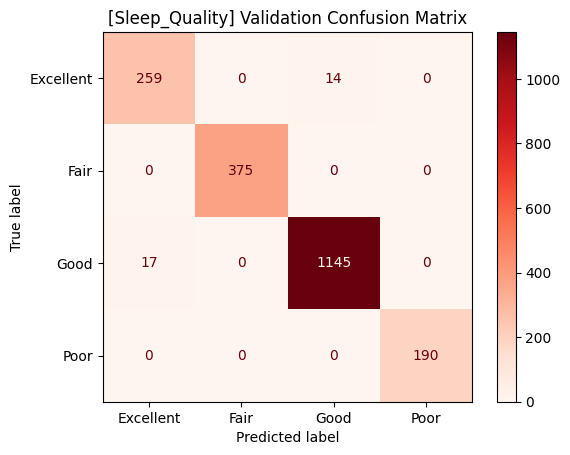

Validation acurracy (%) score: 98.45

Printing classification report for validation:
               precision    recall  f1-score   support

   Excellent       0.94      0.95      0.94       273
        Fair       1.00      1.00      1.00       375
        Good       0.99      0.99      0.99      1162
        Poor       1.00      1.00      1.00       190

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000
 

Epoch 1/20 | loss: 0.4094
Epoch 2/20 | loss: 0.3525
Epoch 3/20 | loss: 0.3312
Epoch 4/20 | loss: 0.1835
Epoch 5/20 | loss: 0.1772
Epoch 6/20 | loss: 0.1506
Epoch 7/20 | loss: 0.2853
Epoch 8/20 | loss: 0.1527
Epoch 9/20 | loss: 0.1136
Epoch 10/20 | loss: 0.1222
Epoch 11/20 | loss: 0.1859
Epoch 12/20 | loss: 0.0805
Epoch 13/20 | loss: 0.1506
Epoch 14/20 | loss: 0.0889
Epoch 15/20 | loss: 0.0932
Epoch 16/20 | loss: 0.0631
Epoch 17/20 | loss: 0.1587
Epoch 18/20 | loss: 0.0732


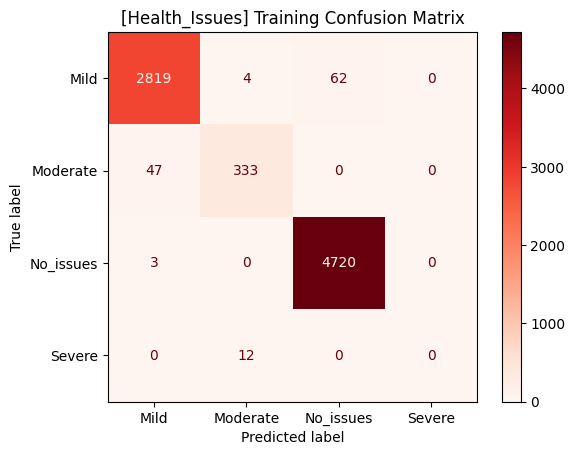

Training acurracy (%) score: 98.4

Printing classification report for training:
               precision    recall  f1-score   support

        Mild       0.98      0.98      0.98      2885
    Moderate       0.95      0.88      0.91       380
   No_issues       0.99      1.00      0.99      4723
      Severe       0.00      0.00      0.00        12

    accuracy                           0.98      8000
   macro avg       0.73      0.71      0.72      8000
weighted avg       0.98      0.98      0.98      8000
 



C:\Users\anhth\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\anhth\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\anhth\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

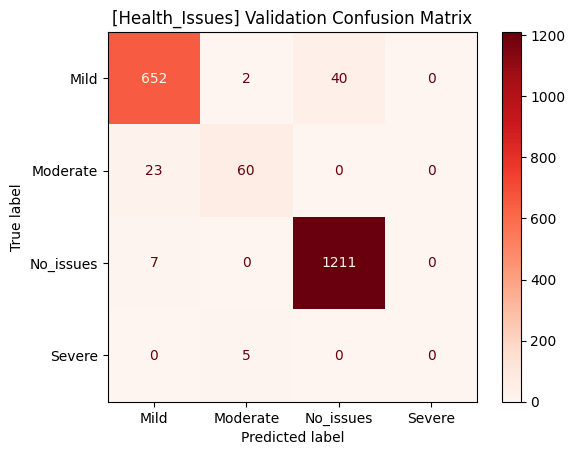

Validation acurracy (%) score: 96.15

Printing classification report for validation:
               precision    recall  f1-score   support

        Mild       0.96      0.94      0.95       694
    Moderate       0.90      0.72      0.80        83
   No_issues       0.97      0.99      0.98      1218
      Severe       0.00      0.00      0.00         5

    accuracy                           0.96      2000
   macro avg       0.70      0.66      0.68      2000
weighted avg       0.96      0.96      0.96      2000
 



C:\Users\anhth\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\anhth\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\anhth\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [84]:

# Sleep_Quality and Health_Issues
list_features = ["Stress_Level", "Sleep_Quality", "Health_Issues"]
list_X_train = [X_train_t_s, X_train_t_sq, X_train_t_h]
list_X_val= [X_val_t_s, X_val_t_sq, X_val_t_h]
list_y_train = [y_train_t_s, y_train_t_sq, y_train_t_h]
list_y_val = [y_val_t_s, y_val_t_sq, y_val_t_h]
list_train_loader = [train_loader_s, train_loader_sq, train_loader_h]
list_val_loader = [val_loader_s,val_loader_sq, val_loader_h]
list_encoder = [encoder_s, encoder_sq, encoder_h]

for i in range(len(list_features)):
    input_size = list_X_train[i].shape[1]
    num_classes = len(list_encoder[i].classes_)

    model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss() # use CrossEntropyLoss as the standard multi-class classification loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    l1_lambda = 1e-4
    epochs = 20

    model_trained = train_nn(model, epochs, l1_lambda, optimizer, criterion, list_train_loader[i])

    acc_train, acc_val, cm_train, cm_val = get_accuracy_cm_nn(model_trained, list_X_train[i], list_X_val[i], list_y_train[i], list_y_val[i], list_features[i], list_encoder[i])
